In [199]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [200]:
import numpy as np
import pandas as pd

In [201]:
import datetime as dt
from datetime import datetime

# Reflect Tables into SQLAlchemy ORM

In [202]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [203]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [204]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [205]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [206]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [207]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [208]:
inspector1 = inspect(engine)
columns = inspector1.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [209]:
# Dynamically find the date 1 year ago from the most recent data point date
r = session.query(Measurement.date).order_by(Measurement.date.desc()).all()
d = [result[0] for result in r]
recent_day = datetime.strptime(d[0], '%Y-%m-%d')
recent_day_year = recent_day.year

previous_year = recent_day_year - 1

year_ago = dt.datetime(previous_year, recent_day.month, recent_day.day, 0, 0)
year_ago = year_ago.strftime('%Y-%m-%d')
year_ago

'2016-08-23'

In [210]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
results1 = session.query(Measurement.date).\
    filter(Measurement.date >= year_ago).all()

date1 = [result[0] for result in results1]

In [211]:
# Calculate the date 1 year ago from the last data point in the database
one_year_date = date1.sort()
one_year_date = date1[0]
one_year_date

'2016-08-23'

In [212]:
# Perform a query to retrieve the data and precipitation scores
results2 = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= one_year_date).\
    filter(Measurement.prcp != "None").all()

In [213]:
# Save the query results as a Pandas DataFrame and set the index to the date column
climate_df = pd.DataFrame(results2, columns=['date', 'precipitation'])
climate_df.set_index('date', inplace=True, )
climate_df.head()

,precipitation
date,
2016-08-23,0.00
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00


In [214]:
# Sort the dataframe by date
climate_df = climate_df.sort_values('date')
climate_df.head()

,precipitation
date,
2016-08-23,0.00
2016-08-23,0.02
2016-08-23,0.05
2016-08-23,0.70
2016-08-23,0.15


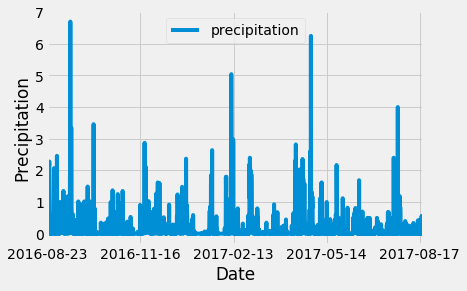

In [215]:
# Use Pandas Plotting with Matplotlib to plot the data
climate_df.plot()
plt.xlabel("Date")
plt.ylabel("Precipitation")
plt.show()

![precipitation](Images/precipitation.png)

In [216]:
# Use Pandas to calculate the summary statistics for the precipitation data
climate_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [217]:
inspector2 = inspect(engine)
columns = inspector2.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [218]:
# Design a query to show how many stations are available in this dataset
results3 = session.query(Station.id, Station.station, Station.name).\
            group_by(Station.id).\
            order_by(Station.id).all()

station_count = session.query(Station.id).count()

print("There are " + str(station_count) + " stations available in this dataset.")

There are 9 stations available in this dataset.


In [219]:
# What are the most active stations? (i.e. what stations have the most rows)?
sel_1 = [Station.station, Measurement.tobs]

same_station = session.query(*sel_1).filter(Measurement.station == Station.station).\
            order_by(Station.station).all()

# List the stations and the counts in descending order (using DataFrame manipulation):

# Load into dataframe
stations_df = pd.DataFrame(same_station, columns=['station', 'temp obs'])

# Set index as station
stations_df.set_index('station', inplace=True, )

# Create new dataframe to group by station and count number of temp obs
station_counts_df = stations_df.groupby(['station']).size().reset_index(name='counts')

# Reset new dataframe index as station
station_counts_df.set_index('station', inplace=True, )

# Sort station counts in descending order
station_counts_df.sort_values(by='counts', ascending=False)

,counts
station,
USC00519281,2772
USC00519397,2724
USC00513117,2709
USC00519523,2669
USC00516128,2612
USC00514830,2202
USC00511918,1979
USC00517948,1372
USC00518838,511


In [220]:
# Using only session.query functions:
station_query = session.query(Measurement.station, func.count(Measurement.station)).\
            group_by(Measurement.station).\
            order_by(func.count(Measurement.station).desc()).all()

station_query

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [221]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

# Find station with highest temp obs count
max_station = station_counts_df['counts'].idxmax()

# Selection criteria with functions
sel_2 = [func.min(Measurement.tobs),
         func.avg(Measurement.tobs),
           func.max(Measurement.tobs)]

# Results query using the most active station as a filter
results4 = session.query(*sel_2).\
    filter(Measurement.station == max_station).all()

# Present results as dataframe
active_station_df = pd.DataFrame(results4, columns=['min temp', 'avg temp', 'max temp'])
active_station_df

,min temp,avg temp,max temp
0,54.0,71.663781,85.0


In [222]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

results4 = session.query(Measurement.station, Measurement.date, Measurement.tobs).\
    order_by(Measurement.date.desc()).\
    filter(Measurement.station == max_station).\
    filter(Measurement.date >= one_year_date).all()

In [223]:
# Read results into a DataFrame
max_station_df = pd.DataFrame(results4, columns=['station', 'date', 'tobs'])
max_station_df.set_index('station', inplace=True, )
max_station_df.head()

,date,tobs
station,,
USC00519281,2017-08-18,79.0
USC00519281,2017-08-17,76.0
USC00519281,2017-08-16,76.0
USC00519281,2017-08-15,77.0
USC00519281,2017-08-14,77.0


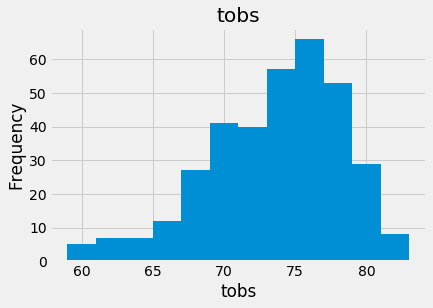

In [224]:
# Plot histogram

max_station_df.hist(bins=12)
plt.ylabel("Frequency")
plt.xlabel("tobs")
plt.show()

![precipitation](Images/station-histogram.png)

In [225]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [226]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates
current_day = d[0]
current_day

'2017-08-23'

In [227]:
year_ago

'2016-08-23'

In [228]:
# Set beginning and end dates for trip
start = '2017-06-01'
end = '2017-06-08'
bonus_1_result = calc_temps(start, end)
bonus_1_result

[(74.0, 77.75, 81.0)]

In [229]:
bonus_1_df = pd.DataFrame(bonus_1_result, columns=['min', 'avg', 'max'])
bonus_1_df.head()

,min,avg,max
0,74.0,77.75,81.0


In [230]:
min_temp = bonus_1_df.iloc[0]['min']
max_temp = bonus_1_df.iloc[0]['max']
avg_temp = bonus_1_df['avg']
peak_to_peak = max_temp - min_temp

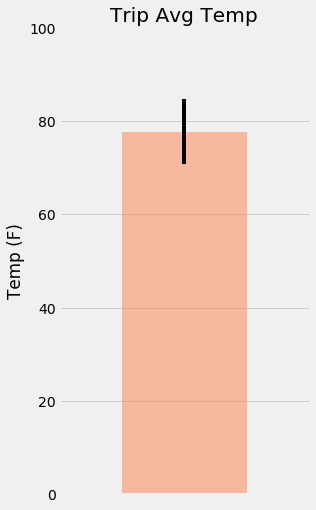

In [231]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

avg_temp.plot(kind='bar', yerr=peak_to_peak, figsize=(4,8), alpha=0.5, color='coral', grid=True)
plt.ylabel('Temp (F)')
plt.title('Trip Avg Temp')
plt.xticks([])
plt.grid(True)
plt.ylim(0,100)
plt.show()

In [232]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

# Previous year's matching dates
previous_start = '2016-06-01'
previous_end = '2016-06-08'

# Query and sort results by descending prcp values
rf_station = session.query(Measurement.date, Measurement.prcp, Measurement.station, Station.name, Station.latitude, Station.longitude, Station.elevation).\
            order_by(Measurement.prcp.desc()).\
            filter(Measurement.date >= previous_start).filter(Measurement.date <= previous_end).\
            filter(Measurement.prcp != "None").\
            filter(Measurement.station == Station.station).all()

# Load into dataframe and present results
rf_station_df = pd.DataFrame(rf_station, columns=['date', 'prcp', 'station', 'name', 'lat', 'lng', 'elevation'])
rf_station_df.set_index('date', inplace=True, )
rf_station_df

,prcp,station,name,lat,lng,elevation
date,,,,,,
2016-06-01,1.40,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4
2016-06-01,1.39,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
2016-06-07,1.26,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4
2016-06-01,0.89,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
2016-06-02,0.74,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4
2016-06-05,0.63,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
2016-06-06,0.52,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
2016-06-02,0.50,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
2016-06-03,0.47,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5


## Optional Challenge Assignment

In [233]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("05-03")

[(67.0, 73.41071428571429, 84.0)]

In [234]:
# Calculate the daily normals for your trip
# Push each tuple of calculations into a list called `normals`
# Use the start and end date to create a range of dates
# Strip off the year and save a list of %m-%d strings

# Set the start and end date of the trip
start2 = '2016-05-01'
end2 = '2016-05-08'

start2 = datetime.strptime(start2, '%Y-%m-%d')
end2 = datetime.strptime(end2, '%Y-%m-%d')

# Calculate number of days to be used for loops
num_days = end2.day - start2.day
num_days = num_days + 1

# Empty lists for datetime objects and final list of %m-%d strings
list_of_unpacked_dates = []
list_of_dates = []
normals = []
list_of_tuples = []

# For loop to generate list of unpacked datetime objects based on number of days and start date
for x in range(0, num_days):
    list_of_unpacked_dates.append(start2 + dt.timedelta(days = x))

list_of_unpacked_dates

[datetime.datetime(2016, 5, 1, 0, 0),
 datetime.datetime(2016, 5, 2, 0, 0),
 datetime.datetime(2016, 5, 3, 0, 0),
 datetime.datetime(2016, 5, 4, 0, 0),
 datetime.datetime(2016, 5, 5, 0, 0),
 datetime.datetime(2016, 5, 6, 0, 0),
 datetime.datetime(2016, 5, 7, 0, 0),
 datetime.datetime(2016, 5, 8, 0, 0)]

In [235]:
# For loop to generate list of dates with the year stripped
for y in range(0, num_days):
    list_of_dates.append(list_of_unpacked_dates[y].strftime('%m-%d'))
    
list_of_dates

['05-01', '05-02', '05-03', '05-04', '05-05', '05-06', '05-07', '05-08']

In [236]:
# Loop through the list of %m-%d strings and calculate the normals for each date
for z in range(0, num_days):
    normals.append(daily_normals(list_of_dates[z]))
    
# Another loop is needed to get only a list of tuples
for a in range(0, num_days):
    list_of_tuples.append(normals[a][0])

list_of_tuples

[(65.0, 72.75925925925925, 79.0),
 (65.0, 73.05084745762711, 79.0),
 (67.0, 73.41071428571429, 84.0),
 (65.0, 73.59649122807018, 78.0),
 (67.0, 73.39655172413794, 79.0),
 (66.0, 73.14035087719299, 80.0),
 (64.0, 71.78846153846153, 79.0),
 (65.0, 72.18867924528301, 80.0)]

In [237]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normals_df = pd.DataFrame(list_of_tuples, columns=['tmin', 'tavg', 'tmax'])

# Insert column of dates
normals_df.insert(2, 'trip dates', list_of_dates)

# Set index as the date column
normals_df = normals_df.set_index('trip dates')
normals_df

,tmin,tavg,tmax
trip dates,,,
05-01,65.0,72.759259,79.0
05-02,65.0,73.050847,79.0
05-03,67.0,73.410714,84.0
05-04,65.0,73.596491,78.0
05-05,67.0,73.396552,79.0
05-06,66.0,73.140351,80.0
05-07,64.0,71.788462,79.0
05-08,65.0,72.188679,80.0


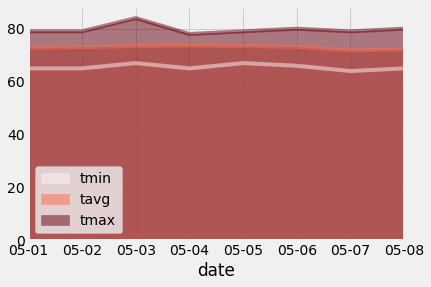

In [238]:
# Plot the daily normals as an area plot with `stacked=False`
normals_df.plot(kind='area', stacked=False, alpha=0.5, colormap='Reds')
plt.xlabel('date')
plt.show()